<h1> Segment credit card customers </h1>

In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [58]:
df = pd.read_csv("customer_segmentation.csv")

<h2> Data Analysis </h2>

In [59]:
#dataset.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   customer_id               10127 non-null  int64  
 1   age                       10127 non-null  int64  
 2   gender                    10127 non-null  object 
 3   dependent_count           10127 non-null  int64  
 4   education_level           10127 non-null  object 
 5   marital_status            10127 non-null  object 
 6   estimated_income          10127 non-null  int64  
 7   months_on_book            10127 non-null  int64  
 8   total_relationship_count  10127 non-null  int64  
 9   months_inactive_12_mon    10127 non-null  int64  
 10  credit_limit              10127 non-null  float64
 11  total_trans_amount        10127 non-null  int64  
 12  total_trans_count         10127 non-null  int64  
 13  avg_utilization_ratio     10127 non-null  float64
dtypes: flo

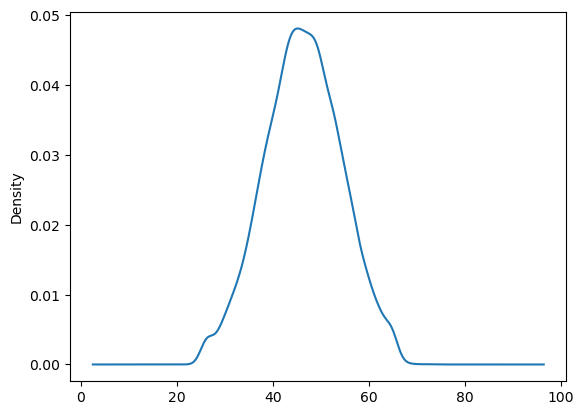

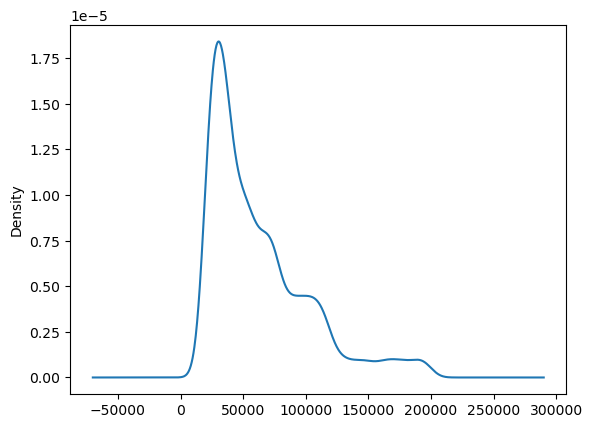

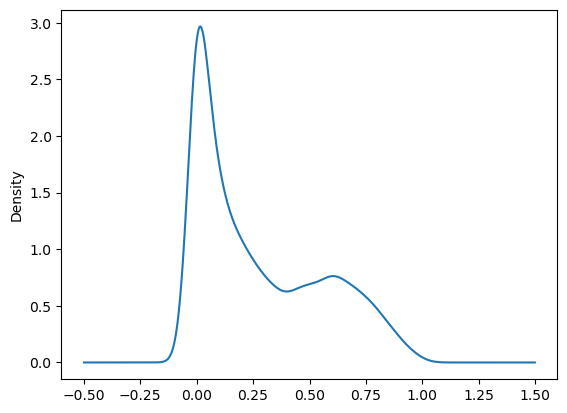

In [60]:
for col in ['age', 'estimated_income', 'avg_utilization_ratio']:
    df[col].plot(kind='kde')
    plt.show()


most customers in the dataset are between 40 ad 60 years old, make less than 50,000 a year, and have a utilization ratio of around 0.00

<h2> Feature Engineering </h2>

In [61]:
customers_modif = df.copy()
customers_modif["gender"] = customers_modif["gender"].apply(lambda a : 1 if a =='M' else 0)
customers_modif.replace(to_replace={'Uneducated': 0, 'High School': 1, 'College':2,
                                    'Graduate': 3, 'Post-Graduate': 4, 'Doctorate':5}, inplace=True)
customers_modif['education_level'].head()

0    1
1    3
2    3
3    1
4    0
Name: education_level, dtype: int64

In [62]:
dummies = pd.get_dummies(customers_modif[['marital_status']], drop_first=True)

customers_modif = pd.concat([customers_modif, dummies], axis=1)
customers_modif.drop(['marital_status'], axis=1, inplace=True)

print(customers_modif.shape)
customers_modif.head()

(10127, 16)


,customer_id,age,gender,dependent_count,education_level,estimated_income,months_on_book,total_relationship_count,months_inactive_12_mon,credit_limit,total_trans_amount,total_trans_count,avg_utilization_ratio,marital_status_Married,marital_status_Single,marital_status_Unknown
0,768805383,45,1,3,1,69000,39,5,1,12691.0,1144,42,0.061,1,0,0
1,818770008,49,0,5,3,24000,44,6,1,8256.0,1291,33,0.105,0,1,0
2,713982108,51,1,3,3,93000,36,4,1,3418.0,1887,20,0.000,1,0,0
3,769911858,40,0,4,1,37000,34,3,4,3313.0,1171,20,0.760,0,0,1
4,709106358,40,1,3,0,65000,21,5,1,4716.0,816,28,0.000,1,0,0


<h2> Scaling the data </h2>

In [63]:
df_withoutID = customers_modif.drop("customer_id",axis=1)
scaler = StandardScaler()
scaler.fit(df_withoutID)
df2 = pd.DataFrame(scaler.transform(df_withoutID))

<h2>Choosing K</h2>

In [64]:
inertia = []
for i in range(1,11):
    K = KMeans(n_clusters = i)
    K.fit_predict(df2)
    inertia.append(K.inertia_)
print(inertia)
    

[151904.99999999994, 134790.15387474862, 123153.33294376708, 112889.29920539955, 104079.4195268184, 98723.37646113666, 94440.0294604718, 91000.72889099122, 88491.96109418759, 86161.59547622793]


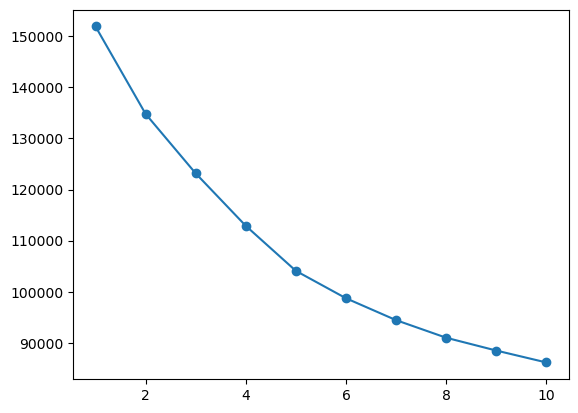

In [65]:
plt.plot(range(1, 11), inertia, marker='o')
plt.show()

In [67]:
K = KMeans(n_clusters = 6)
y = K.fit_predict(df2)
print(y)

[3 2 3 ... 5 0 5]


<h1> Display Results and find segments </h1>

In [70]:
df["CLUSTER"] = y + 1

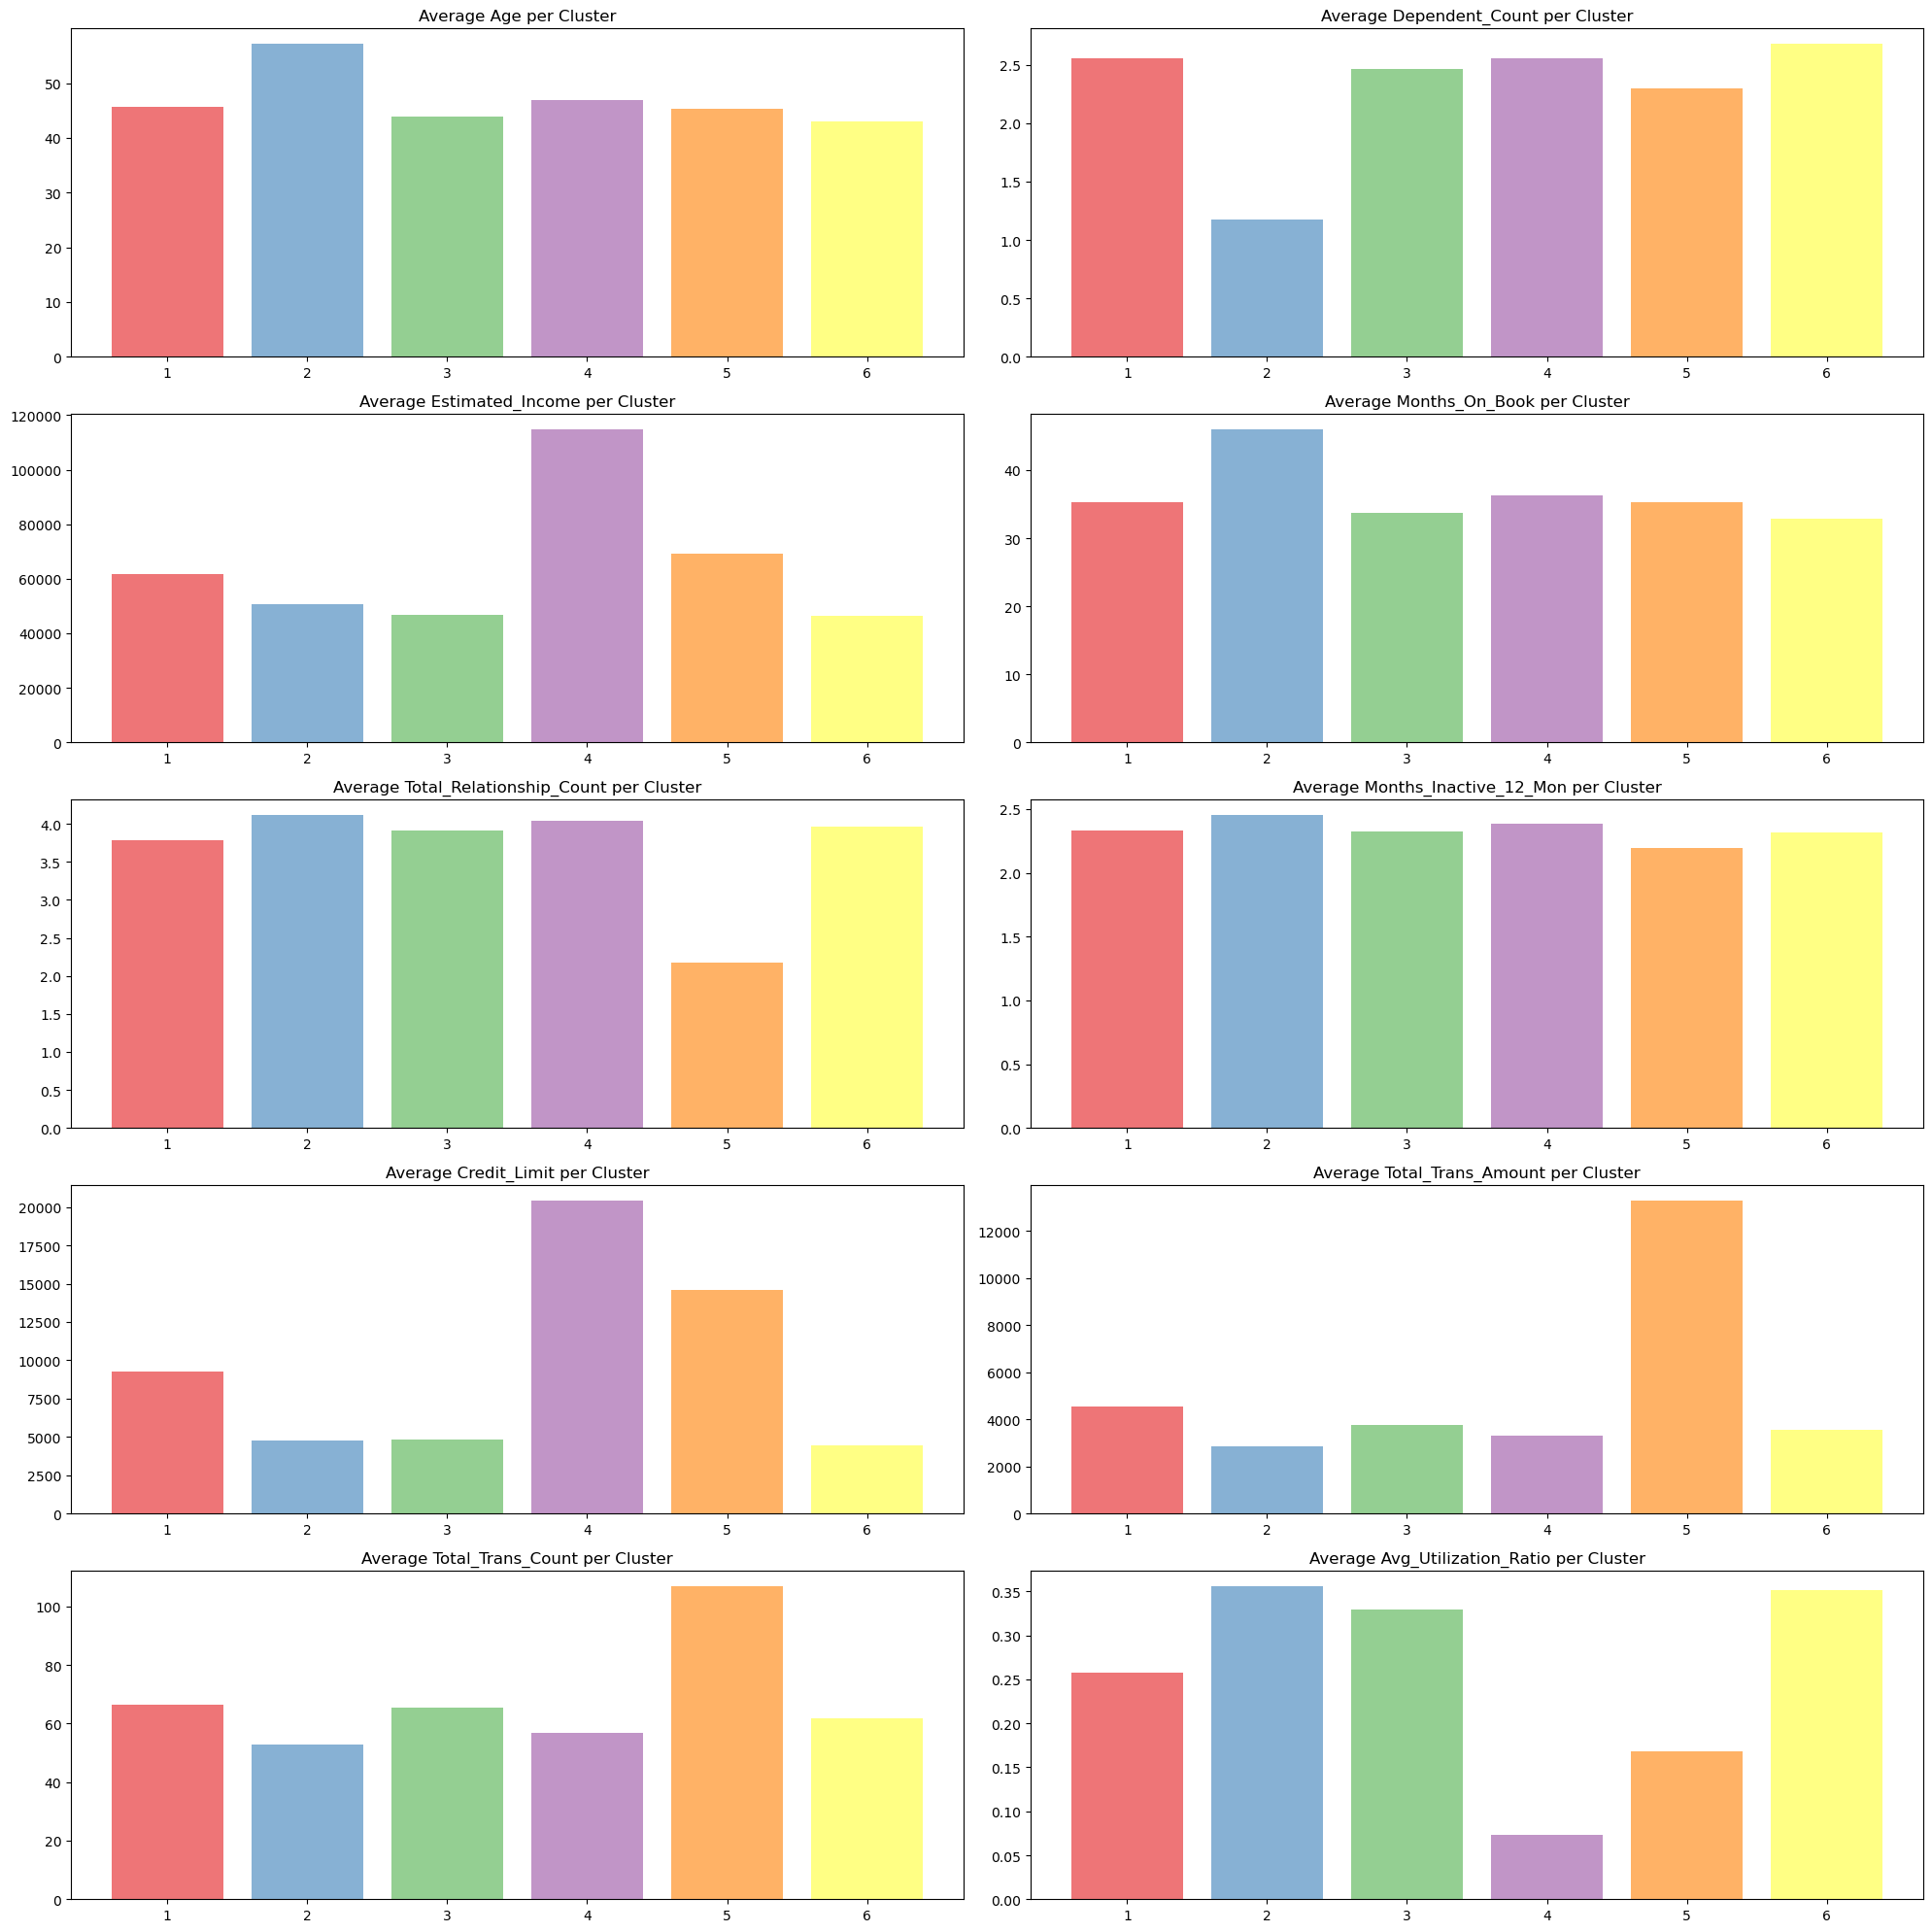

In [73]:
numeric_columns = df.select_dtypes(include=np.number).drop(['customer_id', 'CLUSTER'], axis=1).columns

fig = plt.figure(figsize=(20, 20))
for i, column in enumerate(numeric_columns):
    df_plot = df.groupby('CLUSTER')[column].mean()
    ax = fig.add_subplot(5, 2, i+1)
    ax.bar(df_plot.index, df_plot, color=sns.color_palette('Set1'), alpha=0.6)
    ax.set_title(f'Average {column.title()} per Cluster')
    ax.xaxis.grid(False)
    
plt.tight_layout()
plt.show()

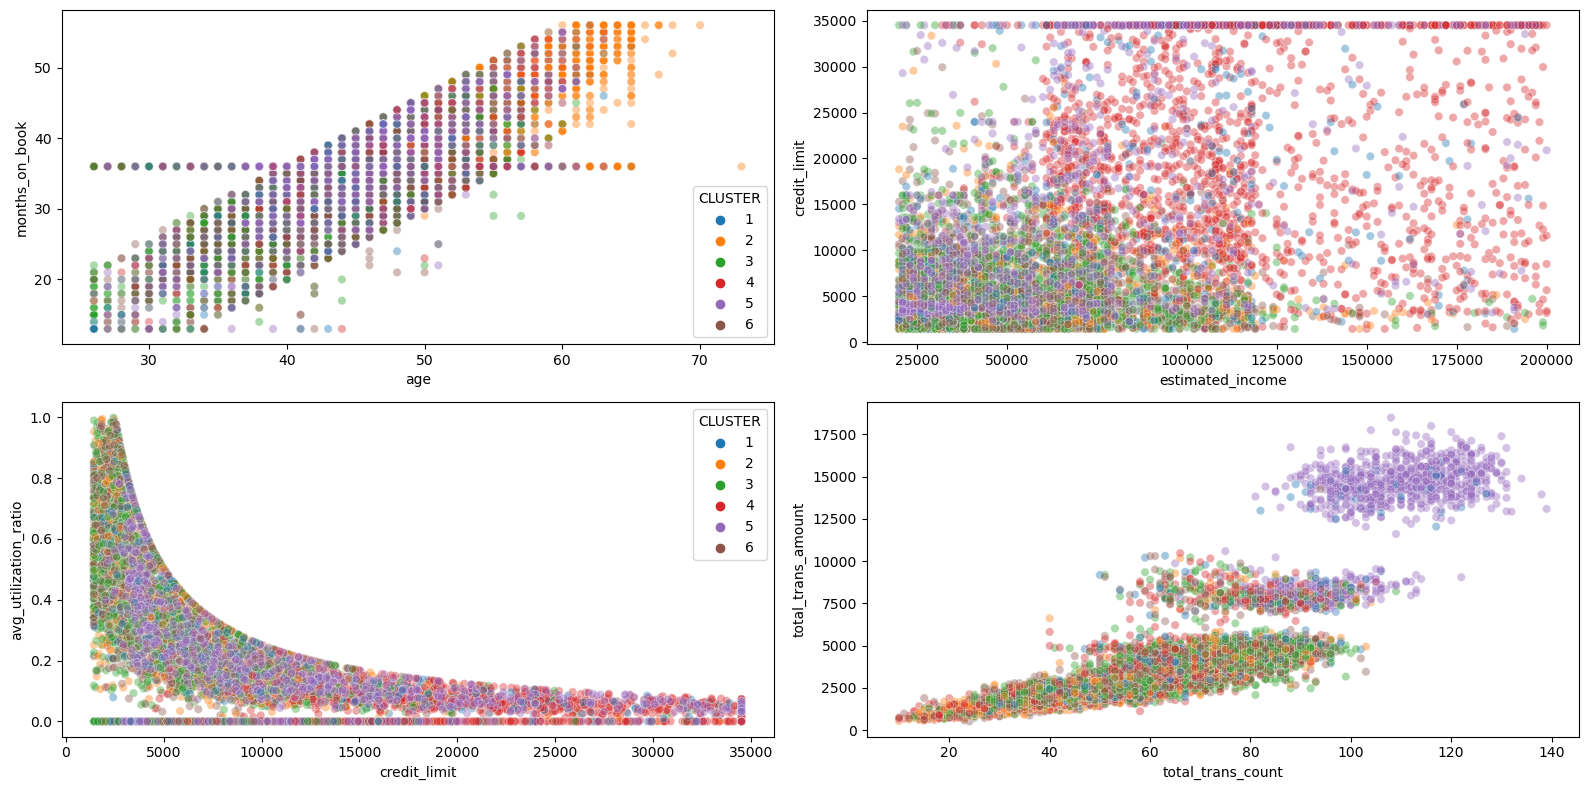

In [75]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 8))
sns.scatterplot(x='age', y='months_on_book', hue='CLUSTER', data=df, palette='tab10', alpha=0.4, ax=ax1)
sns.scatterplot(x='estimated_income', y='credit_limit', hue='CLUSTER', data=df, palette='tab10', alpha=0.4, ax=ax2, legend=False)
sns.scatterplot(x='credit_limit', y='avg_utilization_ratio', hue='CLUSTER', data=df, palette='tab10', alpha=0.4, ax=ax3)
sns.scatterplot(x='total_trans_count', y='total_trans_amount', hue='CLUSTER', data=df, palette='tab10', alpha=0.4, ax=ax4, legend=False)

plt.tight_layout()
plt.show()